## Imports

In [1]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import distance_array
from MDAnalysis import units
from MDAnalysis.analysis import rdf
from openmm.unit import AVOGADRO_CONSTANT_NA, BOLTZMANN_CONSTANT_kB
from openmm.unit import kelvin, bar, litre, kilojoule_per_mole, mole, nanometer, angstrom, kilocalorie_per_mole
from openmm.unit import Quantity, Unit
import quantities
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from pymbar import timeseries
from MDAnalysis.analysis import density
from tqdm import tqdm
import os

/tmp/ipykernel_344671/3999601440.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*            

## Loading data and creating atom group of ions

In [5]:
os.chdir("/home/bamo6610/Documents/openff-dev/SPW_openMM/blanca_output_analysis/SPW_1m/")

In [4]:
print(mda.__version__)

2.7.0


In [7]:
u = mda.Universe('nacl_1m_original.pdb', 'nacl_1m_original.xtc')
u.transfer_to_memory()
ions= u.select_atoms('resname NA CL')

# u1 = mda.Universe('mdr1.gro', 'mdr1.xtc')
# u1.transfer_to_memory()
# ions1= u1.select_atoms('resname SOD CLA')

# u2 = mda.Universe('mdr2.gro', 'mdr2.xtc')
# u2.transfer_to_memory()
# ions2= u2.select_atoms('resname SOD CLA')

# u3 = mda.Universe('mdr3.gro', 'mdr3.xtc')
# u3.transfer_to_memory()
# ions3= u3.select_atoms('resname SOD CLA')




## Function for calculating osmotic values:

### search for    print("---Statistical Analysis results---") and below you will fin the error analysis

In [8]:
def SPW_analysis(u, ions, repnum, 
                 walldist=48, n_part=65, kforce=4184):

## loading data
        
    if repnum == 0:
        print("Data for original run")
    else:
        print("Data for replicate #",repnum)

    box_size = u.dimensions[:3] * angstrom
    wall1=(box_size[2]-walldist*angstrom)/2
    wall2=(box_size[2]+walldist*angstrom)/2
    R = BOLTZMANN_CONSTANT_kB * AVOGADRO_CONSTANT_NA # gas constant

    box_x = box_size[0]
    box_y = box_size[1]

    A_box = box_x * box_y 

    dim_mem = wall2-wall1
    V_mem = A_box * dim_mem
    #print(V_mem)

    M = n_part / (V_mem * AVOGADRO_CONSTANT_NA)

## calculation of osmotic values

    def osmotic_values(mean_force_wall, 
                       molarity :Quantity, vant_hoff : int=2, T=300*kelvin, 
                       cross_sectional_area : Quantity=48*48 * angstrom**2,
                       osm_coeff_exp = 0.94, 
                       printvals = False):
        osm_press=mean_force_wall/cross_sectional_area
        osm_bar = osm_press.in_units_of(bar / mole)
        osm_bar = osm_bar/AVOGADRO_CONSTANT_NA
        osm_press_ideal=vant_hoff*molarity*R*T
        osm_press_ideal=osm_press_ideal.in_units_of(bar)
        osm_coeff=osm_bar/osm_press_ideal
        op_error=(abs(osm_bar-osm_press_ideal)/osm_press_ideal)*100        
        oc_error=(abs(osm_coeff-osm_coeff_exp)/osm_coeff)*100
        
        if printvals:
            print(f"Osmotic Pressure Observed:", osm_bar)
            print(f"Osmotic Pressure Ideal:", osm_press_ideal)
            print(f"Osmotic Coefficient:", osm_coeff)
            # is is nt not really error (not deviatons from experiment),
            # so we won't print them
            #print(f"Osmotic Pressure %Error:", op_error)
            print(f"Osmotic Coefficient %Error:", oc_error)
    
        return osm_bar, osm_coeff

    def calculate_net_force(z_values : np.ndarray[float], zwall : float, k : float) -> float:
        return k * abs(z_values - zwall).sum()

## calculation of mean force

    k_nm = kforce * kilojoule_per_mole / nanometer**2
    k = k_nm.in_units_of(kilojoule_per_mole / angstrom**2)

    walls_z_pos = np.array([walldist,2*walldist]) * angstrom
    forces_at_ts = {1:[],2:[]}
    
    for _ in u.trajectory:

        ions_z = ions.positions[:,2]*angstrom
        
        force_1 = calculate_net_force(
            z_values=ions_z[ions_z < wall1],
            zwall=wall1,
            k=k
        )
        forces_at_ts[1].append(force_1)

        force_2 = calculate_net_force(
            z_values=ions_z[ions_z > wall2],
            zwall=wall2,
            k=k
        )
        forces_at_ts[2].append(force_2)

    mean_forces = {
        abs_wall_z : sum(force_list, start=0*(kilojoule_per_mole / angstrom)) / len(u.trajectory)
            for abs_wall_z, force_list in forces_at_ts.items()
    }

    #print('mean forces =', mean_forces)

## calling calculation of osmotic values
    
    for wall_z_val, mF in mean_forces.items():
        o = osmotic_values(mF, molarity=M, printvals = True, cross_sectional_area=A_box)

    # print("\nAverage between 2 walls: ")
    # av_mF=(mean_forces[48]+mean_forces[96])/2
    # o = osmotic_values(av_mF, molarity=M, cross_sectional_area=A_box)

## plotting force vs time

    fs = {1:list(),2:list()}
    time = []

    for i,ts in enumerate(u.trajectory):
        time.append(u.trajectory.time)
        for j in [1,2]:
            fs[j].append((forces_at_ts[j][i]).item())

    print("----------------------------------------------------------------")

## calculation of autocorrelation function and plot of uncorrelated samples
    meanfs = list()
    varfs = list()
    
    for d in fs.keys():
        f = fs[d]
        fts=np.array(f) # the particular entry, lower or upper wall
        print(f"---Wall {d*walldist/10:.1f} nm---")
        nskip=100
        t0, g, Neff_max = timeseries.detect_equilibration(fts,nskip=nskip) # compute indices of uncorrelated timeseries
        fts_equil = fts[t0:]
        indices = timeseries.subsample_correlated_data(fts_equil, g=g)
        fts_s = fts_equil[indices]
    
        indt=[]
        for i in indices:
            indt.append(time[i])

        #statistical values of t0 (time after equil), g (statistical efficiency/correlation time of equil data), Neff (# of eff samples)
        print('t0 =', t0,' g =',g,' Neff_max =', Neff_max)
        #mean of full time series
        meanf=np.mean(f)
        meanf=meanf*kilojoule_per_mole/angstrom
        #stdev of the full timeseries devided by sqrt of the number of effective samples -1
        sterrf=np.std(f)/np.sqrt(len(indt)-1)
        #Variance calculation
        varf = sterrf**2
        print(f"Mean = {meanf}, std error = {sterrf}, variance = {varf}",'\n')
        meanfs.append(meanf)
        varfs.append(varf)
        
################################################################################################
    
    print("---Statistical Analysis results---")

    #statistical average between two walls
    statmeanF=(meanfs[0]+meanfs[1])/2
    #statistical average between variance of data of two walls
    av_var=(varfs[0]+varfs[1])/2
    # mean std error from average of variances between walls
    errvar=np.sqrt(av_var)

    print(f'Mean force over two walls: {statmeanF}')
    print(f'Std error in mean force over two walls: +/-{errvar:0.3f}')
    
    #asign units to std error of variance 
    errvar=errvar*(kilojoule_per_mole/angstrom)

    print("------------------------------------------------------------------------")

    print(f"FINAL STATISTICAL RESULTS:")
    
    print("------------------------------------------------------------------------")   
    #calculation of osmotic values from statistical mean and std error
    osmval = osmotic_values(statmeanF, molarity=M, cross_sectional_area=A_box) 
    osmerr = osmotic_values(errvar, molarity=M, cross_sectional_area=A_box)

    print(f"Osmotic Pressure = {osmval[0]} +/- {osmerr[0]} \nOsmotic Coefficient = {osmval[1]} +/- {osmerr[1]}")
    print("")
    ################################################################################################
    results = dict()
    
    results['os_pres_val'] = osmval[0]
    results['os_pres_err'] = osmerr[0]
    results['os_coef_val'] = osmval[1]
    results['os_coef_err'] = osmerr[1]
    results['M'] = M
    
    return results

In [9]:
us = [u]
ionss = [ions]
results = list()
for i,(ui,ionsi) in enumerate(zip(us,ionss)):
    results.append(SPW_analysis(ui,ionsi,i))

Data for original run
Osmotic Pressure Observed: 50.29475334040662 bar
Osmotic Pressure Ideal: 48.59911443162526 bar
Osmotic Coefficient: 1.034890325237654
Osmotic Coefficient %Error: 9.169118980396622
Osmotic Pressure Observed: 49.8641182567456 bar
Osmotic Pressure Ideal: 48.59911443162526 bar
Osmotic Coefficient: 1.0260293595863788
Osmotic Coefficient %Error: 8.384687902211654
----------------------------------------------------------------
---Wall 4.8 nm---
t0 = 0  g = 1.0  Neff_max = 251.0
Mean = 6.9912025 kJ/(A mol), std error = 0.5536714965888994, variance = 0.3065521261349916 

---Wall 9.6 nm---
t0 = 0  g = 1.0  Neff_max = 251.0
Mean = 6.931342238769532 kJ/(A mol), std error = 0.6059047899445942, variance = 0.3671206144778028 

---Statistical Analysis results---
Mean force over two walls: 6.961272369384766 kJ/(A mol)
Std error in mean force over two walls: +/-0.580
------------------------------------------------------------------------
FINAL STATISTICAL RESULTS:
---------------

#### (exp_osm_coeff=0.936,molarity=0.976*(mole/litre))
#### (exp_osm_coeff=0.984,molarity=1.923*(mole/litre))
#### (exp_osm_coeff=1.045,molarity=2.823*(mole/litre))

### Ideal Osmotic Pressure: 48.68949309190537 bar at concentraion 0.976 mol/L
### Osmotic Pressure from experimental osmotic coefficient: 45.57336553402343 bar
### Ideal Osmotic Pressure: 95.93226968825209 bar at concentraion 1.923 mol/L
### Osmotic Pressure from experimental osmotic coefficient: 94.39735337324005 bar
### Ideal Osmotic Pressure: 140.83036782627957 bar at concentraion 2.823 mol/L
### Osmotic Pressure from experimental osmotic coefficient: 147.16773437846214 bar


In [4]:
# us = [u,u1,u2,u3]
# ionss = [ions,ions1,ions2,ions3]
# results = list()
# for i,(ui,ionsi) in enumerate(zip(us,ionss)):
#     results.append(SPW_analysis(ui,ionsi,i))

Data for original run
Osmotic Pressure Observed: 48.07871000335531 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.987480729137412
Osmotic Coefficient %Error: 4.808268934917609
Osmotic Pressure Observed: 49.36685608410063 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 1.0139377499468538
Osmotic Coefficient %Error: 7.292138984935649
----------------------------------------------------------------
---Wall 4.8 nm---
t0 = 0  g = 1.2604113  Neff_max = 794.97864
Mean = 6.670926931954765 kJ/(A mol), std error = 0.33895818033590214, variance = 0.11489264801662595 

---Wall 9.6 nm---
t0 = 0  g = 3.180632  Neff_max = 315.0317
Mean = 6.849657359242321 kJ/(A mol), std error = 0.5338343057367497, variance = 0.2849790659814376 

---Statistical Analysis results---
Mean force over two walls: 6.760292145598543 kJ/(A mol)
Std error in mean force over two walls: +/-0.447
------------------------------------------------------------------------
FINAL STATI

### Stdev between replicates

In [5]:
print(results)

[{'os_pres_val': Quantity(value=48.7227830437278, unit=bar), 'os_pres_err': Quantity(value=3.2226412897528727, unit=bar), 'os_coef_val': 1.0007092395421293, 'os_coef_err': 0.06618930021898281, 'M': Quantity(value=9.759751100106701e-28, unit=mole/(angstrom**3))}, {'os_pres_val': Quantity(value=50.72604040991329, unit=bar), 'os_pres_err': Quantity(value=2.7470341403958147, unit=bar), 'os_coef_val': 1.0418538136056323, 'os_coef_err': 0.0564208830838871, 'M': Quantity(value=9.759751100106701e-28, unit=mole/(angstrom**3))}, {'os_pres_val': Quantity(value=50.78625117475679, unit=bar), 'os_pres_err': Quantity(value=2.7092749585711706, unit=bar), 'os_coef_val': 1.0430904726167713, 'os_coef_err': 0.05564535344931018, 'M': Quantity(value=9.759751100106701e-28, unit=mole/(angstrom**3))}, {'os_pres_val': Quantity(value=49.894526817040614, unit=bar), 'os_pres_err': Quantity(value=2.8117664537228824, unit=bar), 'os_coef_val': 1.0247754924751304, 'os_coef_err': 0.057750409436788476, 'M': Quantity(val

In [11]:
# def results_replicates(results):
op_vals = list()
oc_vals = list()
op_errs = list()
oc_errs = list()

for r in results:
    v = r['os_pres_val']
    op_vals.append(v.value_in_unit(v.unit))
    v = r['os_pres_err']
    op_errs.append(v.value_in_unit(v.unit))
    oc_vals.append(r['os_coef_val'])
    oc_errs.append(r['os_coef_err'])
oc_vals = np.array(oc_vals)
op_vals = np.array(op_vals)
op_errs = np.array(op_errs)
oc_errs = np.array(oc_errs)

print('op replicates')
print(op_vals)
print('oc replicates')
print(oc_vals)

print('op replicates errs')
print(op_errs)
print('oc replicates errs')
print(oc_errs)


print("std over replicates")
stdop = op_vals.std(ddof=1)
print(f'std of osmotic presssure: {stdop:.3f}')
stdoc = oc_vals.std(ddof=1)
print(f'std of osmotic coeff: {stdoc:.3f}')

print("mean of op replicates: ",end="")
print(f'osmotic pressure {op_vals.mean():.3f} +/- {stdop/np.sqrt(len(op_vals)):.3f}')
print("mean of oc replicates: ",end="")
print(f'osmotic coeff {oc_vals.mean():.3f} +/- {stdoc/np.sqrt(len(oc_vals)):.3f}')

    # final_results = dict()

    # final_results['conc'] = concs[0]
    # final_results['stdev_op'] = stdop
    # final_results['stdev_oc'] = stdoc
    # final_results['mean_op'] = op_vals.mean()
    # final_results['mean_oc'] = oc_vals.mean()
    # final_results['op_errs'] = stdop/np.sqrt(len(op_vals))
    # final_results['oc_errs'] = stdoc/np.sqrt(len(oc_vals))

    # return final_results


op replicates
[48.72278304 50.72604041 50.78625117 49.89452682]
oc replicates
[1.00070924 1.04185381 1.04309047 1.02477549]
op replicates errs
[3.22264129 2.74703414 2.70927496 2.81176645]
oc replicates errs
[0.0661893  0.05642088 0.05564535 0.05775041]
std over replicates
std of osmotic presssure: 0.963
std of osmotic coeff: 0.020
mean of op replicates: osmotic pressure 50.032 +/- 0.482
mean of oc replicates: osmotic coeff 1.028 +/- 0.010


### Density profiles using GROMACS

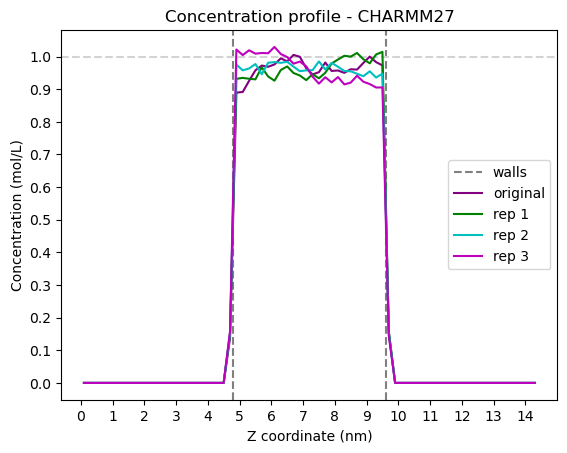

In [7]:
x,y = np.loadtxt("density_original.xvg",comments=["@", "#"],unpack=True)
y=(y/nanometer**3)/(AVOGADRO_CONSTANT_NA)
y=y.in_units_of(mole/litre)/2
x1,y1 = np.loadtxt("dens_r1.xvg",comments=["@", "#"],unpack=True)
y1=(y1/nanometer**3)/(AVOGADRO_CONSTANT_NA)
y1=y1.in_units_of(mole/litre)/2
x2,y2 = np.loadtxt("dens_r2.xvg",comments=["@", "#"],unpack=True)
y2=(y2/nanometer**3)/(AVOGADRO_CONSTANT_NA)
y2=y2.in_units_of(mole/litre)/2
x3,y3 = np.loadtxt("dens_r3.xvg",comments=["@", "#"],unpack=True)
y3=(y3/nanometer**3)/(AVOGADRO_CONSTANT_NA)
y3=y3.in_units_of(mole/litre)/2
plt.axvline(x = 4.8, color = 'gray', label = 'walls', linestyle = 'dashed')
plt.axvline(x = 9.6, color = 'gray', linestyle = 'dashed')
plt.axhline(y = 1, color = 'lightgray', linestyle = 'dashed')
plt.plot(x,y, c='purple', label='original')
plt.plot(x1,y1, c='g', label='rep 1')
plt.plot(x2,y2, c='c', label='rep 2')
plt.plot(x3,y3, c='m', label='rep 3')
plt.xlabel("Z coordinate (nm)")
plt.ylabel("Concentration (mol/L)")
plt.xticks(np.arange(0, 14.4, 1.0))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title('Concentration profile - CHARMM27')
plt.legend()
#plt.savefig("volume.png", format="png", dpi=300)
plt.show()

## Density profiles using MDanalysis

In [8]:
def density_profile(universe, atom_group, bin_width=0.5, dim='z', method='atom', frameby=1):
    '''Calculate the partial density across the box'''

    if isinstance(atom_group, str): # if provided selection language, make AtomGroup
        ag = universe.select_atoms(atom_group)
    else: # else assume input is AtomGroup
        ag = atom_group

    print(f'\nCalculating the partial density profile of {atom_group} in the {dim} dimension...')

    dims = {'x': 0, 'y': 1, 'z': 2}
    d = dims[dim]
    box = universe.dimensions[d]

    n_bins = int(box / bin_width)
    bins = np.linspace(0, box, num=n_bins)

    counts = np.zeros(n_bins-1)
        
    if len(universe.trajectory) == 0:
        for b in tqdm(range(n_bins-1)):
            lb = bins[b]
            ub = bins[b+1]
            bin_atoms = universe.select_atoms(f'prop {dim} > {lb} and prop {dim} < {ub} and group ag', ag=ag)
            if method in ['atom', 'atoms', 'all']:
                counts[b] += len(bin_atoms)
            elif method in ['molecule', 'mol', 'residue', 'res']: 
                counts[b] += bin_atoms.n_residues
            elif method in ['mass', 'mass density']:
                box_dims = [box[i] for i in range(3) if i != d]
                dV = box_dims[0] * box_dims[1] * (ub-lb) * (10**-8)**3
                mass = bin_atoms.masses.sum() / 6.022 / 10**23
                counts[b] += mass / dV
    else:
        for ts in tqdm(universe.trajectory[::frameby]):
            for b in range(n_bins-1):
                lb = bins[b]
                ub = bins[b+1]
                bin_atoms = universe.select_atoms(f'prop {dim} > {lb} and prop {dim} < {ub} and group ag', ag=ag)

                if method in ['atom', 'atoms', 'all', 'number']:
                    counts[b] += len(bin_atoms)                 
                elif method in ['molecule', 'mol', 'residue', 'res']: 
                    counts[b] += bin_atoms.n_residues
                elif method in ['mass', 'mass density']:
                    box_dims = [box[i] for i in range(3) if i != d]
                    dV = box_dims[0] * box_dims[1] * (ub-lb) * (10**-8)**3
                    mass = bin_atoms.masses.sum() / 6.022 / 10**23
                    counts[b] += mass / dV

        counts = counts / len(universe.trajectory[::frameby])

    return bins, counts

In [9]:
# nbins,ncounts=density_profile(u,ions,2)
# nbins1,ncounts1=density_profile(u1,ions1,2)
# nbins2,ncounts2=density_profile(u2,ions2,2)
# nbins3,ncounts3=density_profile(u3,ions3,2)

### Density plots

In [10]:
nb=144.4/72
volbin=48*48*nb*angstrom**3
counts=(ncounts/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2
counts1=(ncounts1/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2
counts2=(ncounts2/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2
counts3=(ncounts3/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2

bins=nbins/10
bins1=nbins1/10
bins2=nbins2/10
bins3=nbins3/10

print(counts)

plt.axvline(x = 4.8, color = 'gray', label = 'walls', linestyle = 'dashed')
plt.axvline(x = 9.6, color = 'gray', linestyle = 'dashed')
plt.axhline(y = 1, color = 'lightgray', linestyle = 'dashed')
plt.plot(bins[1:],counts, c='orange', label='original')
plt.plot(bins1[1:],counts1, c='g', label='rep1')
plt.plot(bins2[1:],counts2, c='c', label='rep2')
plt.plot(bins3[1:],counts3, c='m', label='rep3')

plt.xlabel("Z coordinate (nm)")
plt.ylabel("Concentration (mol/L)")
plt.xticks(np.arange(0, 14.4, 1))
plt.title("Concentration profile of replicates - CHARMM27")
plt.legend()
plt.show()

NameError: name 'ncounts' is not defined